# Description

This notebook uses the observation-based quantile-scaled maximum temperature distributions to evaluate discrete probability ratios between the modern warming period (i.e., the "forced" period) and the counterfactual (related to the "natural" period) in order to visualize the global fingerprint in the attribution analysis; for more information on these periods and their global means, see [hadcrut_GMST.ipynb](hadcrut_GMST.ipynb).

The probability ratios (PRs)---calculated as a function of specific quantiles or query maximum temperatures---are used as estimates of the attributable changes at each location and month; in this notebook we plot the monthly maps of median-scaling-derived PRs.

**FIGURES PRODUCED IN THIS CODE**
* [Fig. S6](./paper_figures/si/figS5.pdf)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import utilities as util
import analysisfx as analysis
from calendar import monthrange
import pandas as pd

# ignore depreciation warnings in this code
import warnings
warnings.filterwarnings("ignore")

# define the locations to save the figures into
fig_main_savepath='./paper_figures/main/'
fig_si_savepath='./paper_figures/si/'

In [2]:
# set up things for plots
monstr=['J','F','M','A','M','J','J','A','S','O','N','D']
cmapgray=plt.get_cmap('viridis').copy()
cmapgray.set_under(color="gray",alpha=0.5)
mongrid_center=np.arange(12)

# Load Data

### Define the Coordinates of the  Cities/Locations of Interest for this study

In [3]:
# define the city locations by longitude/latitude coordinates
cities={
    'phoenix':[util.lon180to360(-112.07404),33.448376],
    'nairobi':[36.8219,-1.2921],
    'cape_town':[28.0473,-26.2041],
    'bengaluru':[77.5946,12.9716],
    'mildura':[142.1367,-34.2069],
    'asuncion':[util.lon180to360(-57.5759),-25.2637],
    'warsaw':[21.0122,52.2297],
    }
# store in a pandas table and display
cities_df=pd.DataFrame(cities,index=['lon','lat'])
display(cities_df)
# save to files
cities_savepath='./data/analysis/cities.csv'
cities_df.to_csv(cities_savepath)

,phoenix,nairobi,cape_town,bengaluru,mildura,asuncion,warsaw
lon,247.925960,36.8219,28.0473,77.5946,142.1367,302.4241,21.0122
lat,33.448376,-1.2921,-26.2041,12.9716,-34.2069,-25.2637,52.2297


### Load+Organize Expected Number of Counts Metadata

In [4]:
# load expected number of counts metadata from pathway
natcountspath='./data/analysis/Ndays_Expected.nc'
natcountdat=xr.open_dataset(natcountspath)

In [5]:
# choose and check the quantile of interest
pp=96.667
qq=pp/100

# Load a data-slicing function to coordinate with the expected number of counts metadata
# ...test the function and grab the chosen dataset given our quantile
ppitest=util.get_1percentile_natcounts(pp,natcountdat)
# print the test to screen
display(ppitest)

# define a quantile grid for analyses
ppgrid=np.array([90,95,96.667,97.5,99])
qgrid=ppgrid/100

<xarray.Dataset>
Dimensions:              (mon: 12, seas: 4)
Coordinates:
    pp                   float64 96.67
  * mon                  (mon) object 'J' 'F' 'M' 'A' 'M' ... 'S' 'O' 'N' 'D'
  * seas                 (seas) object 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    MonthlyExceedance    (mon) float64 ...
    MonthlySubceedance   (mon) float64 ...
    SeasonalExceedance   (seas) float64 ...
    SeasonalSubceedance  (seas) float64 ...
    AnnualExceedance     float64 ...
    AnnualSubceedance    float64 ...
Attributes:
    Dataset Unit:  Number of Days Equal to or Exceeding OR Subceeding the per...

### Setup Loading Distribution Data

In [6]:
# set up scaled distributions data info
q50_loadpath='./data/analysis/q50_mon{month:02d}_scaled_distributions.nc'

# (define the months array from loaded data)
monthsi=np.arange(1,13)

### Load in the Berkeley data land-sea mask

In [7]:
# define the path and load the lsm
lsm_loadpath='/home/dgilford/fingerprints/data/analysis/paper/berkeley_lsm.nc'
lsm=xr.open_dataset(lsm_loadpath)

# Calculate Monthly Exceedances: 96.7th percentile

In [8]:
# define the variable names
prname='PR'
forcedname,cfname='forced','counterfactual'

In [9]:
# loop over quantiles of interest
for qj in np.array(qgrid[2:3]):
    
    # where are we in the loop?
    print('quantile='+str(qj))
    
    # get the expected number of monthly counts for the quantile slice
    qjdat=util.get_1percentile_natcounts(qj*100,natcountdat)

    # loop over all the months
    for mi in monthsi:

        # load monthly data
        q50_datin=xr.open_dataset(q50_loadpath.format(month=mi))
        
        # get the monthly temperature threshold from the CF, associated with the quantile
        Tthresh_qj=q50_datin[cfname].quantile(qj,dim='time')
        
        # calculate the PR associated with the counterfactual temperatures
        q50_pr_mi=analysis.calculate_PR_Tthresh(q50_datin,Tthresh_qj, \
                                             forced=forcedname,cf=cfname, \
                                             dim='time')
        del q50_datin
        # reorganize the output into an xarray dataset
        q50_pr_mi=q50_pr_mi.rename(prname).to_dataset()

        # apply land-sea mask: fill all ocean areas with missing
        q50_pr_mi=q50_pr_mi[prname].where(lsm==True).rename({'lsm':prname})
        
        # merge into a single dataset
        if mi==1:
            q50_pr=q50_pr_mi.copy(deep=True)
            q50_Tthresh=Tthresh_qj.copy(deep=True)
        else:
            q50_pr=xr.merge([q50_pr,q50_pr_mi])
            q50_Tthresh=xr.merge([q50_Tthresh, Tthresh_qj])
        del q50_pr_mi, Tthresh_qj
        
        # where are we in the loop?
        print('mon index='+str(mi))



quantile=0.96667
mon index=1
mon index=2
mon index=3
mon index=4
mon index=5
mon index=6
mon index=7
mon index=8
mon index=9
mon index=10
mon index=11
mon index=12


# Global Map each Month (96.7th percentile)

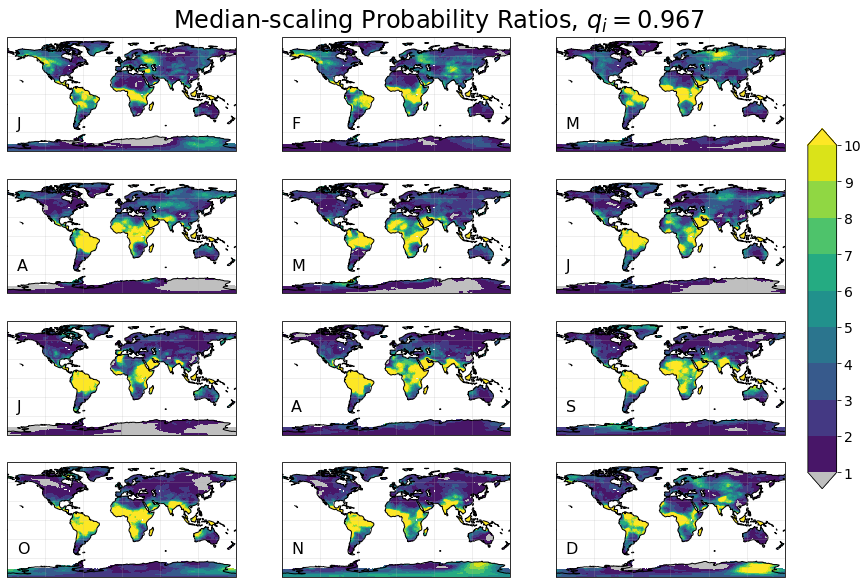

In [10]:
# set up plots for this quantile
fig=plt.figure(figsize=(16,10))

# loop over all the months
for mi in monthsi:
        
        # extract the data we need
        PR_mi=q50_pr[prname].sel(month=mi)

        ## PLOT
        # wrap around the prime meridian before plotting
        PR_mi_cyc = util.xr_add_cyclic_point(PR_mi, 'lon')
    
        # plot the result
        ax = plt.subplot(4, 3, mi, projection=ccrs.PlateCarree())

        levs=np.arange(1,10+1,1)
        datp=ax.contourf(PR_mi_cyc.lon,PR_mi_cyc.lat,PR_mi_cyc, \
                            levels=levs, transform=ccrs.PlateCarree(), \
                            cmap=cmapgray, extend='both')

        # draw the coastlines
        ax.coastlines()
        ax.gridlines(alpha=0.25)
        
        # add the month string
        plt.text(-165,-53,monstr[mi-1],fontsize=16,transform=ccrs.PlateCarree())
        
        # clean up
        PR_mi

# make a single large colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.25, 0.025, 0.5])
ticklabs = cbar_ax.get_yticklabels()
cbar_ax.set_yticklabels(ticklabs, fontsize=14)
fig.colorbar(datp, cax=cbar_ax)

# write the full figure's title
fig.suptitle('Median-scaling Probability Ratios, $q_i='+str(round(qj,3))+'$', fontsize=24, y=0.92)

# save the plot out
plot_save_name='figS5.pdf'
fig.savefig(fig_si_savepath+plot_save_name, dpi=300, bbox_inches='tight')